In [ ]:
pip install git+https://github.com/kevinsbello/dagma.git
pip install git+https://github.com/xunzheng/notears

  Cloning https://github.com/kevinsbello/dagma.git to c:\users\mmkorshunova\appdata\local\temp\pip-req-build-zvfffyd0
  Resolved https://github.com/kevinsbello/dagma.git to commit 088616885d71b56c0573cd4902c1fcbac02e649f
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for dagma: filename=dagma-0.0.0-py3-none-any.whl size=21784 sha256=1f413e9bcf7f2653c90a6c740d0243448710bc1bc6122cd1cc9dbeb08b45ec40
  Stored in directory: C:\Users\mmkorshunova\AppData\Local\Temp\pip-ephem-wheel-cache-1gn2j70_\wheels\fa\a1\df\17bb6598f2d8d7acfbdd1e2ad5ec405e3c741a0b494bbd0022
Successfully built dagma
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/kevinsbello/dagma.git 'C:\Users\mmkorshunova\AppData\Local\Temp\pip-req-build-zvfffyd0'

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from dagma import utils as dagma_utils
from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear
from notears import utils as notears_utils
from notears import linear
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import os
import time

In [ ]:
utils.set_random_seed(42)

## NOTEARS

In [ ]:
def run_expt_notears(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale, expt_name):
    os.mkdir(expt_name)
    os.chmod(expt_name, 0o777)
    perf = defaultdict(list)
    total_time = 0

    for ii in tqdm(range(num_graph)):
        B_true = notears_utils.simulate_dag(d, s0, graph_type)
        W_true = notears_utils.simulate_parameter(B_true, w_ranges=w_ranges)
        W_true_fn = os.path.join(expt_name, f'graph{ii:05}_W_true.csv')
        np.savetxt(W_true_fn, W_true, delimiter=',')
        for jj in range(num_data_per_graph):
            X = notears_utils.simulate_linear_sem(W_true, n, sem_type, noise_scale=noise_scale)
            X_fn = os.path.join(expt_name, f'graph{ii:05}_data{jj:05}_X.csv')
            np.savetxt(X_fn, X, delimiter=',')

            # notears
            start_time = time.time()  # Начало замера времени
            W_notears = linear.notears_linear(X, lambda1=0, loss_type='l2')
            end_time = time.time()  # Конец замера времени
            total_time += (end_time - start_time)

            assert notears_utils.is_dag(W_notears)
            W_notears_fn = os.path.join(expt_name, f'graph{ii:05}_data{jj:05}_W_notears.csv')
            np.savetxt(W_notears_fn, W_notears, delimiter=',')
            # eval
            B_notears = (W_notears != 0)
            acc = notears_utils.count_accuracy(B_true, B_notears)
            for metric in acc:
                perf[metric].append(acc[metric])
    # print stats
    print("NOTEARS", expt_name)
    print(f"Total time: {total_time:.2f} seconds")
    for metric in perf:
        print(metric, f'{np.mean(perf[metric]):.4f}', '+/-', f'{np.std(perf[metric]):.4f}')

    return total_time, perf


### DIM = 2

In [ ]:
num_graph = 1000
num_data_per_graph = 1

n, d, s0, graph_type, sem_type = np.inf, 2, 1, 'ER', 'gauss'

# equal variance
w_ranges = ((-2.0, -0.5), (0.5, 2.0))
noise_scale = [1., 1.]
expt_name = 'equal_var'
run_expt_notears(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale, expt_name)

# large a
w_ranges = ((-2.0, -1.1), (1.1, 2.0))
noise_scale = [1., 0.15]
expt_name = 'large_a'
run_expt_notears(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale, expt_name)

# small a
w_ranges = ((-0.9, -0.5), (0.5, 0.9))
noise_scale = [1, 0.15]
expt_name = 'small_a'
run_expt_notears(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale, expt_name)



100%|██████████| 1000/1000 [01:43<00:00,  9.71it/s]


equal_var
fdr 0.4870 +/- 0.4998
tpr 0.5130 +/- 0.4998
fpr 0.4870 +/- 0.4998
shd 0.4870 +/- 0.4998
nnz 1.0000 +/- 0.0000


100%|██████████| 1000/1000 [01:45<00:00,  9.51it/s]


large_a
fdr 0.0080 +/- 0.0891
tpr 0.9920 +/- 0.0891
fpr 0.0080 +/- 0.0891
shd 0.0080 +/- 0.0891
nnz 1.0000 +/- 0.0000


 88%|████████▊ | 880/1000 [01:44<00:19,  6.04it/s]c:\Users\mmkorshunova\Study\AIM\NLA\.venv\Lib\site-packages\notears\linear.py:60: RuntimeWarning: overflow encountered in scalar multiply
  obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
c:\Users\mmkorshunova\Study\AIM\NLA\.venv\Lib\site-packages\notears\linear.py:61: RuntimeWarning: overflow encountered in multiply
  G_smooth = G_loss + (rho * h + alpha) * G_h
100%|██████████| 1000/1000 [01:57<00:00,  8.50it/s]

small_a
fdr 0.4680 +/- 0.4990
tpr 0.5320 +/- 0.4990
fpr 0.4680 +/- 0.4990
shd 0.4680 +/- 0.4990
nnz 1.0000 +/- 0.0000


Эти показатели — метрики, которые используются для оценки качества восстановления направленных ацикличных графов (DAG) после обучения методом. Давайте разберем каждую метрику и её значение:

---

### **1. FDR (False Discovery Rate)**
- **Определение**: Доля ложноположительных связей среди всех предсказанных связей.
\[
\text{FDR} = \frac{\text{FP}}{\text{FP} + \text{TP}}
\]
- **Где**:
  - FP (False Positives): Ложноположительные связи, предсказанные в графе, но отсутствующие в истинном графе.
  - TP (True Positives): Истинно положительные связи, предсказанные и существующие в графе.

- **Интерпретация**:
  - Значение близкое к \( 0 \): Мало ложных положительных связей, алгоритм работает хорошо.
  - Значение близкое к \( 1 \): Большое количество ложных связей, низкая точность предсказания.

---

### **2. TPR (True Positive Rate)** или **Recall**
- **Определение**: Доля истинных положительных связей среди всех истинных связей.
\[
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\]
- **Где**:
  - FN (False Negatives): Истинные связи, которые не были предсказаны алгоритмом.

- **Интерпретация**:
  - Значение близкое к \( 1 \): Алгоритм успешно восстанавливает большинство истинных связей.
  - Значение близкое к \( 0 \): Алгоритм пропускает большое количество истинных связей.

---

### **3. FPR (False Positive Rate)**
- **Определение**: Доля ложноположительных связей среди всех отсутствующих связей в истинном графе.
\[
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
\]
- **Где**:
  - TN (True Negatives): Отсутствующие связи, которые правильно не были предсказаны.

- **Интерпретация**:
  - Значение близкое к \( 0 \): Алгоритм редко предсказывает ложные связи.
  - Значение близкое к \( 1 \): Алгоритм предсказывает множество ложных связей.

---

### **4. SHD (Structural Hamming Distance)**
- **Определение**: Количество изменений (добавление, удаление или изменение направления связи), необходимых для превращения предсказанного графа в истинный граф.
\[
\text{SHD} = \text{FP} + \text{FN} + \text{Wrong directions}
\]
- **Интерпретация**:
  - Значение \( 0 \): Полное совпадение предсказанного и истинного графов.
  - Чем выше значение, тем больше расхождений между графами.

---

### **5. NNZ (Non-Zero Weights Count)**
- **Определение**: Среднее количество ненулевых весов (связей) в предсказанных графах.
- **Интерпретация**:
  - В данном случае \( \text{NNZ} = 1.0000 \): Алгоритм предсказал в среднем одну связь в графе.

---

### **Объяснение результатов**

#### **Эксперимент 1: `equal_var`**
- **FDR = 0.487**: Почти половина предсказанных связей оказались ложными.
- **TPR = 0.513**: Алгоритм восстановил чуть более половины истинных связей.
- **FPR = 0.487**: Высокий уровень ложных положительных связей.
- **SHD = 0.487**: Среднее количество изменений, необходимых для приведения графа к истинному.
- **NNZ = 1.000**: В каждом графе алгоритм предсказал ровно одну связь.

**Вывод**: Алгоритм работает на уровне случайного угадывания (50% точности).

---

#### **Эксперимент 2: `large_a`**
- **FDR = 0.008**: Очень низкий уровень ложноположительных связей, метод точен.
- **TPR = 0.992**: Почти все истинные связи восстановлены.
- **FPR = 0.008**: Практически отсутствуют ложноположительные связи.
- **SHD = 0.008**: Графы почти полностью совпадают с истинными.
- **NNZ = 1.000**: В каждом графе предсказано ровно одно ребро.

**Вывод**: Алгоритм хорошо справляется с задачей, достигая почти идеальной точности.

---

#### **Эксперимент 3: `small_a`**
- **FDR = 0.468**: Почти половина предсказанных связей ложные.
- **TPR = 0.532**: Чуть больше половины истинных связей восстановлено.
- **FPR = 0.468**: Высокий уровень ложноположительных связей.
- **SHD = 0.468**: Значительные расхождения между предсказанными и истинными графами.
- **NNZ = 1.000**: В каждом графе предсказана одна связь.

**Вывод**: Алгоритм вновь работает на уровне случайного угадывания, как в первом эксперименте.

---

### **Заключение**

1. **`large_a`** демонстрирует, что алгоритм NOTEARS работает лучше всего, когда веса связей \( W \) значительно различаются между собой (интервал весов более широкий).
2. В случае **`equal_var`** и **`small_a`**, когда веса связей близки или вариация мала, алгоритм теряет способность различать истинные и ложные связи.
3. Метрики FDR, TPR, и SHD дают полное представление о качестве восстановления графов, а NNZ подтверждает, что алгоритм предсказывает ровно одну связь на каждом этапе.

### DIM = 20

In [30]:
num_graph = 100
num_data_per_graph = 1

n, d, s0, graph_type, sem_type = 100, 20, 17, 'ER', 'gauss'

# equal variance
w_ranges = ((-1.0, -0.4), (0.4, 1.0))  # Умеренные веса для 20 переменных
noise_scale = [0.5] * d  # Одинаковая низкая дисперсия шума для всех переменных
expt_name = 'dim_20/equal_var'
run_expt_notears(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale, expt_name)

# large a
w_ranges = ((-3.0, -1.5), (1.5, 3.0))  # Сильные зависимости для ключевых связей
noise_scale = [1.0] * (d // 2) + [0.2] * (d // 2)  # Высокий шум для половины переменных, низкий для остальных
expt_name = 'dim_20/large_a'
run_expt_notears(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale, expt_name)

# small a
w_ranges = ((-0.6, -0.3), (0.3, 0.6))  # Слабые зависимости
noise_scale = [0.8] * (d // 3) + [0.5] * (d // 3) + [0.3] * (d // 3)  # Умеренный шум, варьирующийся для подгрупп переменных
eexpt_name = 'dim_20/small_a'
run_expt_notears(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale, expt_name)



100%|██████████| 100/100 [10:03<00:00,  6.04s/it]


dim_20/equal_var
fdr 0.2975 +/- 0.1129
tpr 0.8953 +/- 0.0929
fpr 0.0392 +/- 0.0187
shd 7.2200 +/- 3.4600
nnz 22.0000 +/- 2.7423


 97%|█████████▋| 97/100 [1:19:27<02:27, 49.15s/it]


KeyboardInterrupt: 

## DAGMA

In [ ]:
def run_expt_dagma(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale, expt_name):
    os.mkdir(expt_name)
    os.chmod(expt_name, 0o777)
    perf = defaultdict(list)
    total_time = 0
    
    for _ in tqdm(range(num_graph)):
        B_true = dagma_utils.simulate_dag(d, s0, graph_type)
        W_true = dagma_utils.simulate_parameter(B_true)
        X = dagma_utils.simulate_linear_sem(W_true, n, sem_type)

        start_time = time.time()  # Начало замера времени
        model = DagmaLinear(loss_type='l2')
        W_est = model.fit(X, lambda1=0.02)
        end_time = time.time()  # Конец замера времени
        total_time += (end_time - start_time)
        
        B_est = (W_est != 0)
        acc = dagma_utils.count_accuracy(B_true, B_est)
        for metric in acc:
            perf[metric].append(acc[metric])
    
    print("DAGMA", expt_name)
    print(f"Total time: {total_time:.2f} seconds")
    for metric in perf:
        print(f'{metric}: {np.mean(perf[metric]):.4f} +/- {np.std(perf[metric]):.4f}')
    
    return total_time, perf

## Сравнение алгоритмов

In [82]:
def run_expt_notears(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale):
    perf = defaultdict(list)
    total_time = 0

    for _ in tqdm(range(num_graph)):
        B_true = notears_utils.simulate_dag(d, s0, graph_type)
        W_true = notears_utils.simulate_parameter(B_true, w_ranges=w_ranges)

        for _ in range(num_data_per_graph):
            X = notears_utils.simulate_linear_sem(W_true, n, sem_type, noise_scale=noise_scale)

            # notears
            start_time = time.time()  # Начало замера времени
            W_notears = linear.notears_linear(X, lambda1=0, loss_type='l2')
            end_time = time.time()  # Конец замера времени
            total_time += (end_time - start_time)

            assert notears_utils.is_dag(W_notears)

            # eval
            B_notears = (W_notears != 0)
            acc = notears_utils.count_accuracy(B_true, B_notears)
            for metric in acc:
                perf[metric].append(acc[metric])

    return total_time, perf
    

def run_expt_dagma(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale):
    perf = defaultdict(list)
    total_time = 0
    
    for _ in tqdm(range(num_graph)):
        B_true = dagma_utils.simulate_dag(d, s0, graph_type)
        W_true = dagma_utils.simulate_parameter(B_true)
        X = dagma_utils.simulate_linear_sem(W_true, n, sem_type)

        start_time = time.time()  # Начало замера времени
        model = DagmaLinear(loss_type='l2')
        W_est = model.fit(X, lambda1=0.02)
        end_time = time.time()  # Конец замера времени
        total_time += (end_time - start_time)
        
        B_est = (W_est != 0)
        acc = dagma_utils.count_accuracy(B_true, B_est)
        for metric in acc:
            perf[metric].append(acc[metric])

    return total_time, perf


In [ ]:
# Функция для запуска всех экспериментов с различными параметрами
def run_all_experiments(num_graph=1, n=100, num_data_per_graph=1, sizes=[20, 40, 60],
                         graph_types=['ER', 'SF'], noise_types=['gauss', 'exp', 'uniform']):
    '''
    num_graph = 1  # Количество графов для статистики 10
    n = 100
    num_data_per_graph = 1  # Количество данных для каждого графа
    sizes = [20, 40, 60]  # Размеры графов
    graph_types = ['ER', 'SF']  # Типы графов
    noise_types = ['gauss', 'exp', 'uniform']  # Типы шума gauss, exp, gumbel, uniform, logistic, poisson
    '''

    results = defaultdict(list)
    i = 0
    for d in sizes:
        for graph_type in graph_types:
            for noise_type in noise_types:
                w_ranges = ((-1.0, -0.4), (0.4, 1.0))
                d_1 = int(0.8*d)
                noise_scale = [0.5] * d
                print(f'{i}\n')
                i += 1
                # Запуск эксперимента для NOTEARS
                time_notears, perf_notears = run_expt_notears(num_graph, num_data_per_graph, n, d, d_1, graph_type, noise_type, w_ranges, noise_scale)

                # Запуск эксперимента для DAGMA
                time_dagma, perf_dagma = run_expt_dagma(num_graph, num_data_per_graph, n, d, d_1, graph_type, noise_type, w_ranges, noise_scale)
                
                # Собираем результаты
                results['d'].append(d)
                results['graph_type'].append(graph_type)
                results['noise_type'].append(noise_type)
                results['time_notears'].append(time_notears)
                results['time_dagma'].append(time_dagma)
                results['shd_notears'].append(np.mean(perf_notears['shd']))
                results['shd_dagma'].append(np.mean(perf_dagma['shd']))
                results['tpr_notears'].append(np.mean(perf_notears['tpr']))
                results['tpr_dagma'].append(np.mean(perf_dagma['tpr']))
                results['fdr_notears'].append(np.mean(perf_notears['fdr']))
                results['fdr_dagma'].append(np.mean(perf_dagma['fdr']))

    return results

# Запуск всех экспериментов и построение графиков
results = run_all_experiments()

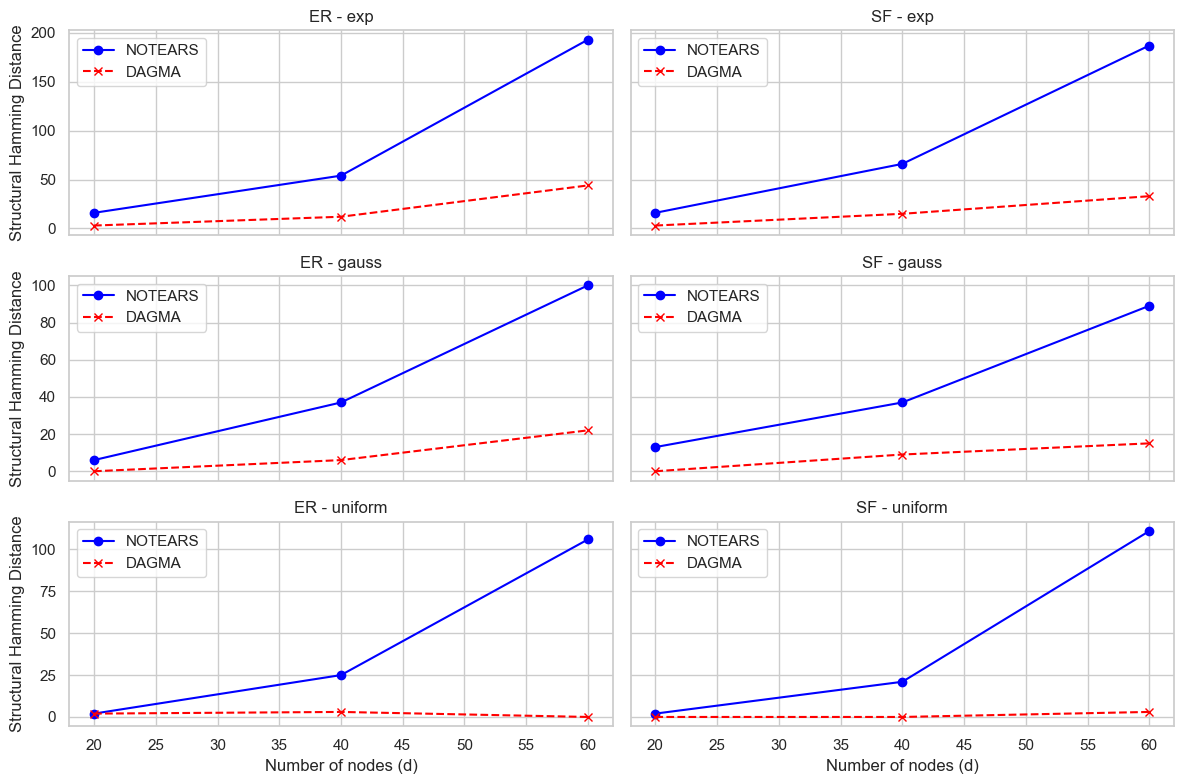

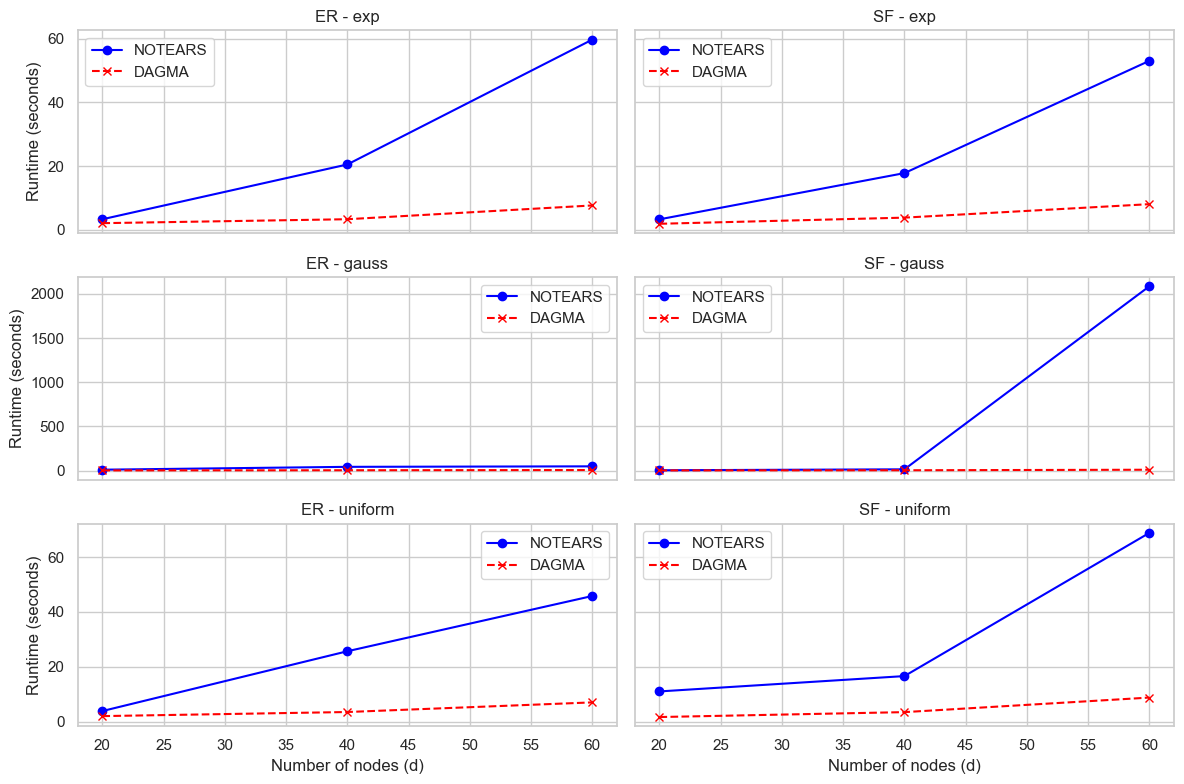

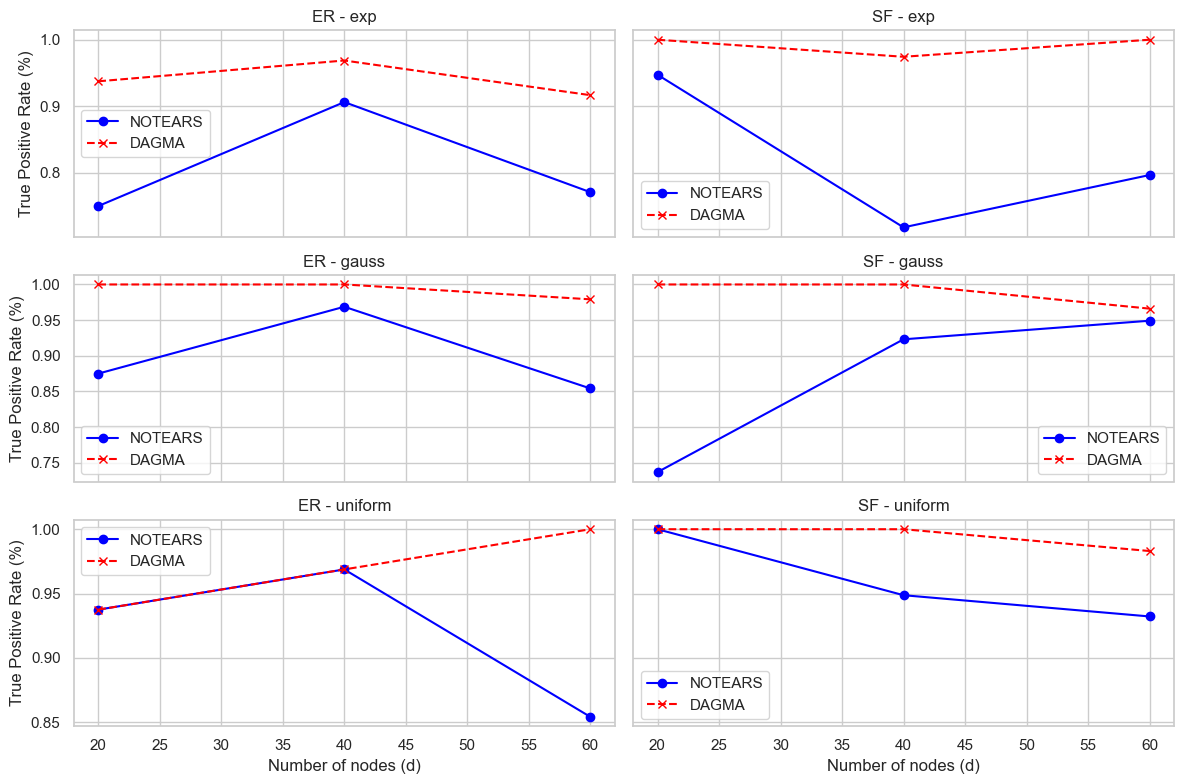

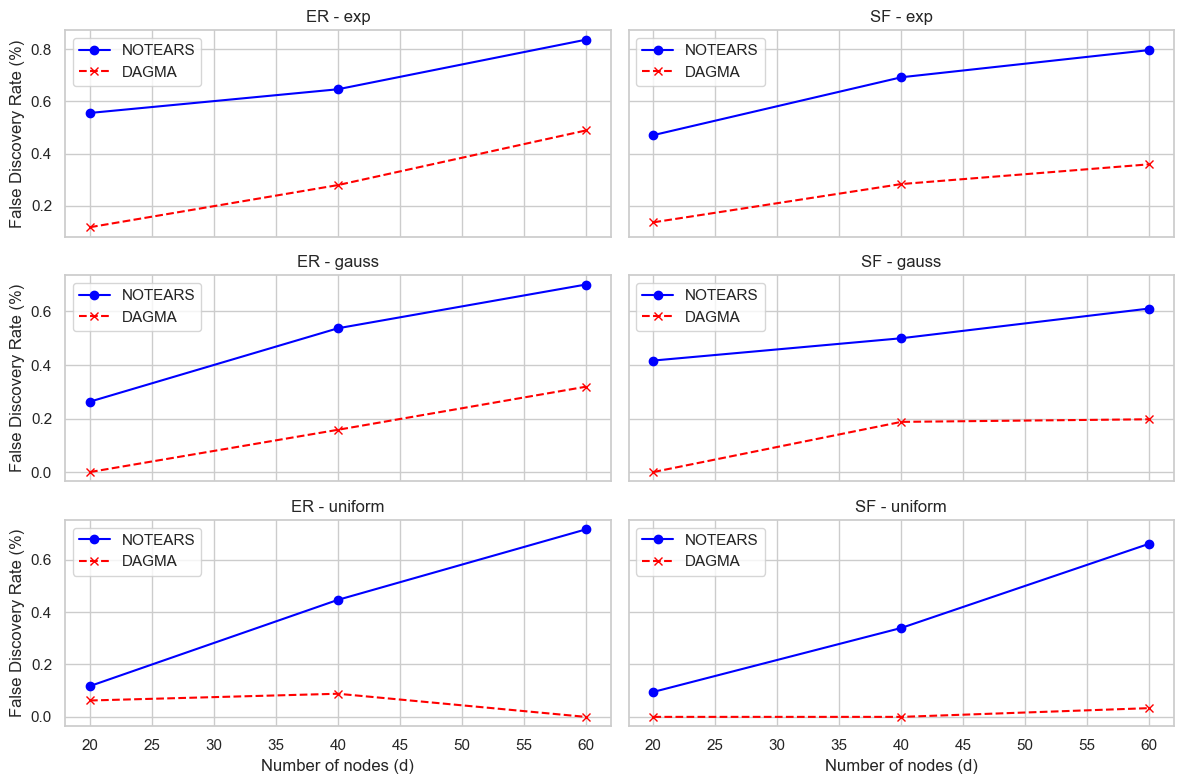

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict

# Установим стиль для графиков
sns.set(style="whitegrid", font_scale=1.0)

# Функция для построения графиков
def plot_results(results):
    # Уникальные значения параметров
    d_values = np.unique(results['d'])
    graph_types = np.unique(results['graph_type'])
    noise_types = np.unique(results['noise_type'])

    # Метрики и их названия
    metrics = {
        'shd': 'Structural Hamming Distance',
        'time': 'Runtime (seconds)',
        'tpr': 'True Positive Rate (%)',
        'fdr': 'False Discovery Rate (%)'
    }

    # Методы и стили
    methods = ['notears', 'dagma']
    colors = ['blue', 'red']
    line_styles = ['-', '--']
    markers = ['o', 'x']

    # Построение графиков для каждой метрики
    for metric, metric_name in metrics.items():
        fig, axes = plt.subplots(len(noise_types), len(graph_types), figsize=(12, 8), sharex=True, sharey='row')
        
        # Проход по типам шума и графиков
        for i, noise_type in enumerate(noise_types):
            for j, graph_type in enumerate(graph_types):
                ax = axes[i, j] if len(noise_types) > 1 else axes[j]  # Корректировка для одномерных осей

                for method, color, style, marker in zip(methods, colors, line_styles, markers):
                    # Формируем данные
                    y_values = [
                        results[f'{metric}_{method}'][k] 
                        for k in range(len(results['d']))
                        if results['graph_type'][k] == graph_type and results['noise_type'][k] == noise_type
                    ]
                    x_values = [
                        results['d'][k] 
                        for k in range(len(results['d']))
                        if results['graph_type'][k] == graph_type and results['noise_type'][k] == noise_type
                    ]
                    # Построение графиков
                    ax.plot(x_values, y_values, label=f'{method.upper()}', linestyle=style, marker=marker, color=color)
                
                # Подписи заголовков и осей
                ax.set_title(f"{graph_type} - {noise_type}")
                if i == len(noise_types) - 1:
                    ax.set_xlabel("Number of nodes (d)")
                if j == 0:
                    ax.set_ylabel(metric_name)
                ax.legend()

        # Общая настройка и вывод
        plt.tight_layout()
        plt.show()

# Пример запуска
plot_results(results)


In [88]:
results = run_all_experiments(num_graph=1, n=500, num_data_per_graph=1, sizes=[20, 40, 60, 80, 100],
                         graph_types=['ER', 'SF'], noise_types=['gauss', 'exp', 'logistic'])

0



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


1



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


2



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


3



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


4



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


5



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


6



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


7



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


8



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


9



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.25s/it]


10



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


11



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


12



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


13



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:05<00:00,  5.89s/it]


14



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


15



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


16



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:06<00:00,  6.20s/it]


17



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.22s/it]


18



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:28<00:00, 28.01s/it]


19



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:27<00:00, 27.48s/it]


20



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:15<00:00, 15.04s/it]


21



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:25<00:00, 25.87s/it]


22



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:30<00:00, 30.50s/it]


23



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.92s/it]


24



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [15:45<00:00, 945.74s/it]


25



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:10<00:00, 70.78s/it]


26



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:15<00:00, 75.52s/it]


27



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [22:52<00:00, 1372.99s/it]


28



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:08<00:00, 68.58s/it]


29



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:48<00:00, 48.76s/it]


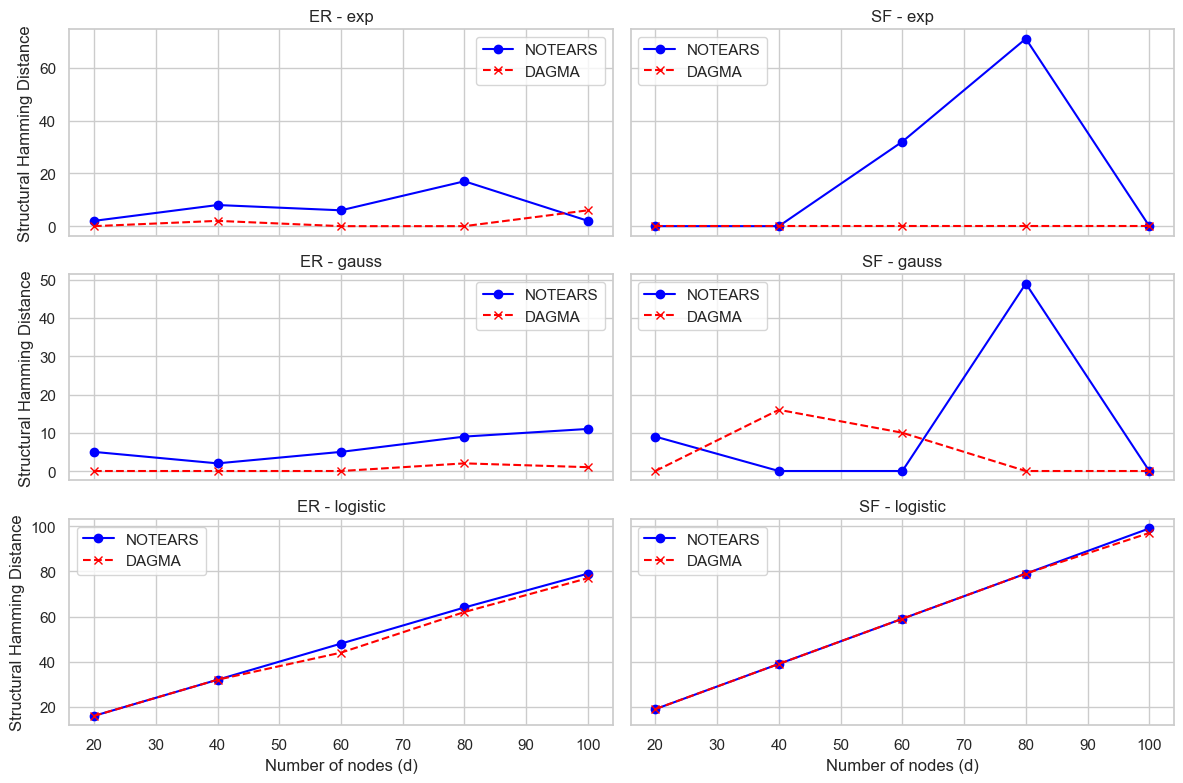

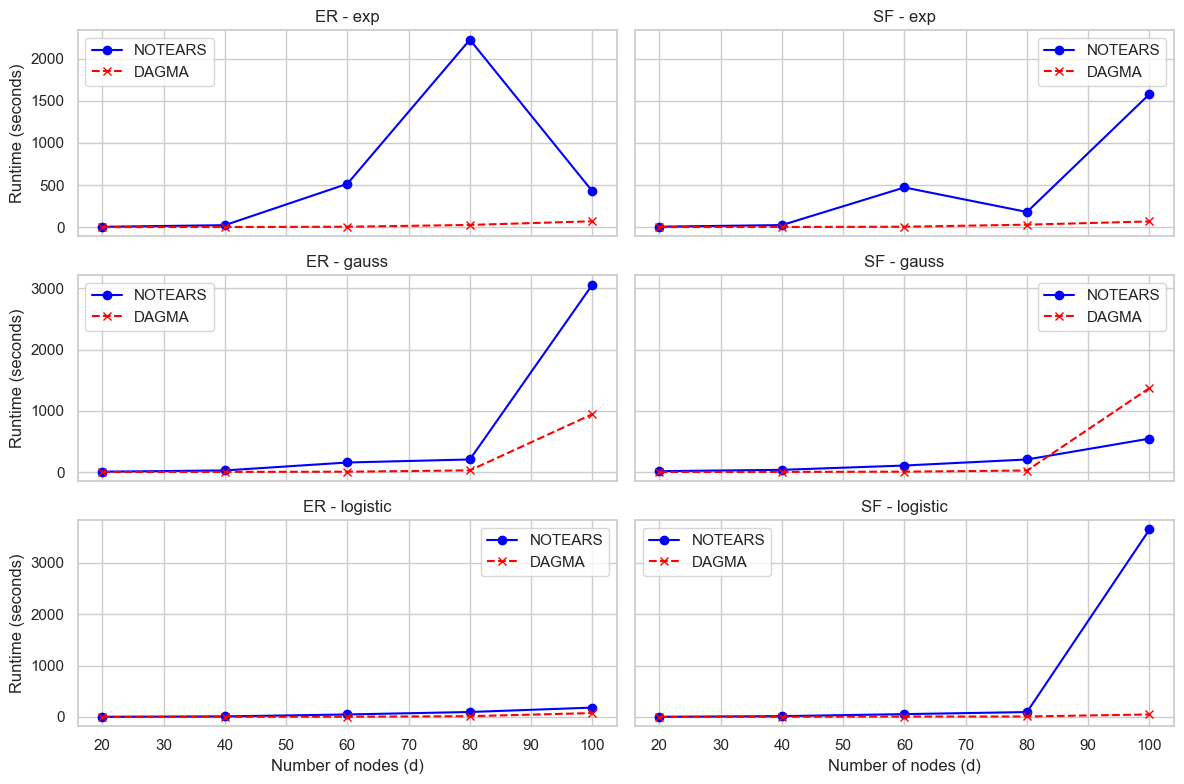

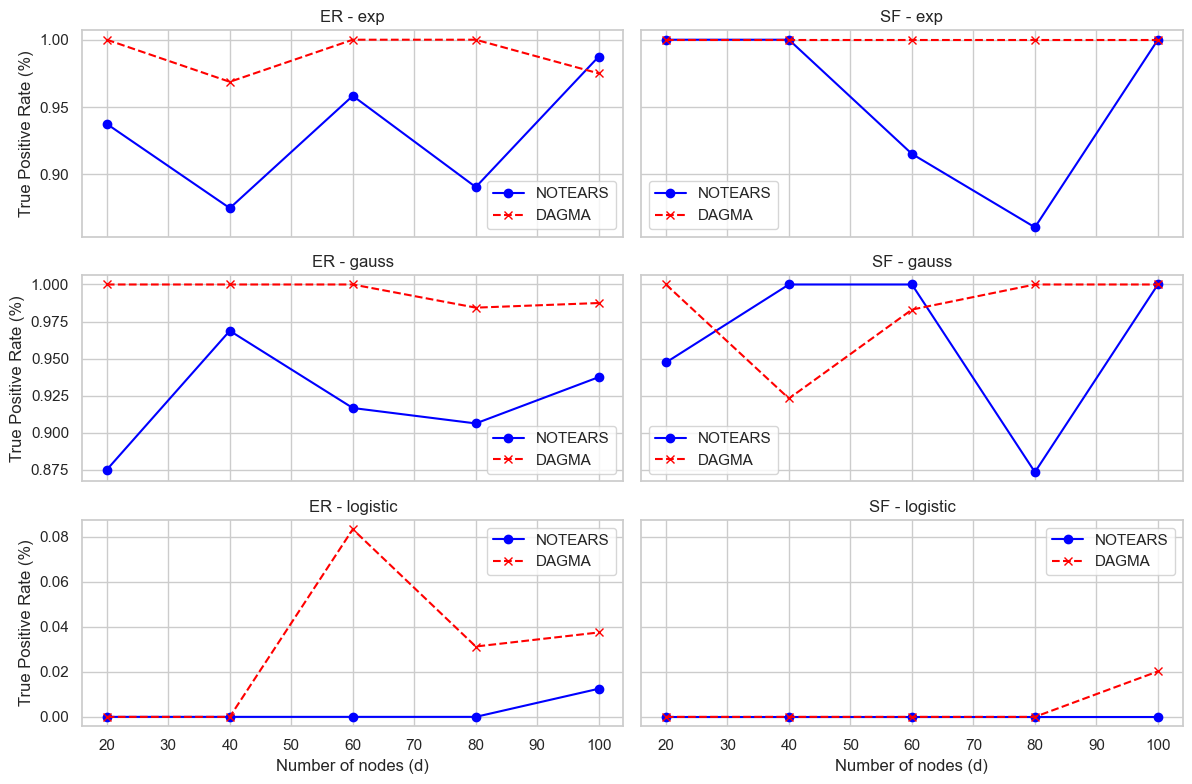

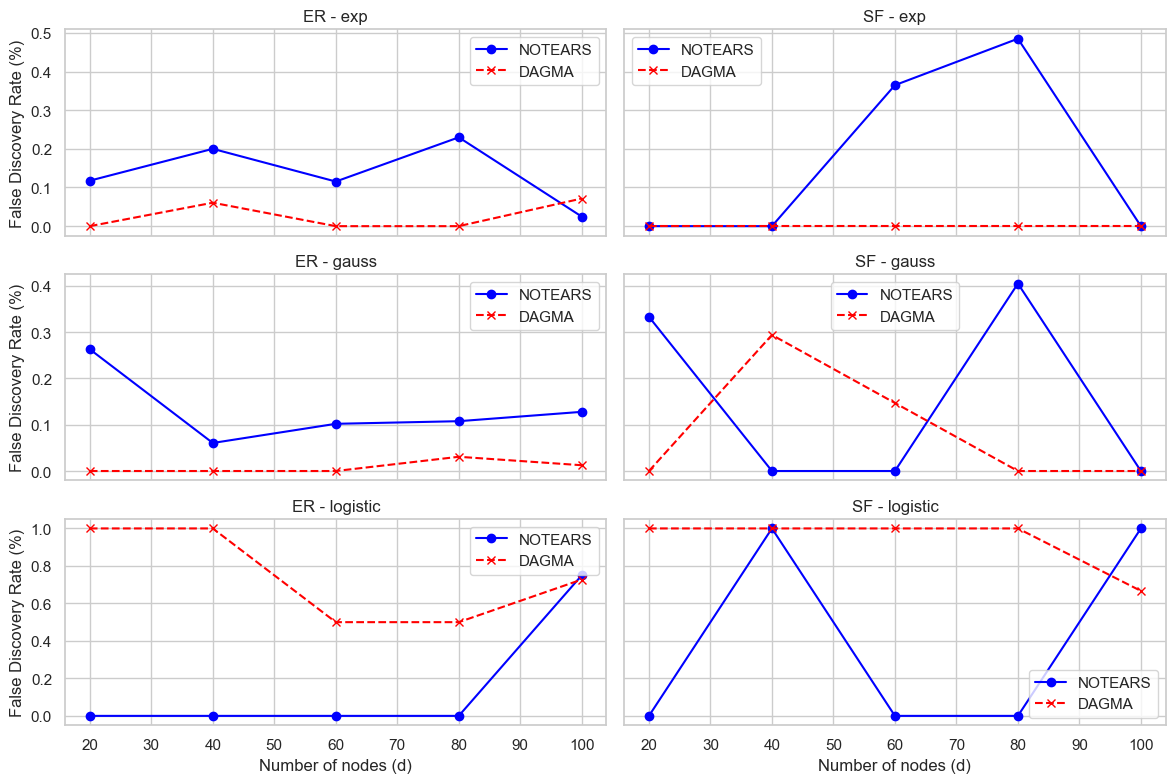

In [89]:
plot_results(results)

In [ ]:
num_graph = 100
num_data_per_graph = 1
n, d, s0, graph_type, sem_type = 100, 20, 17, 'ER', 'gauss'

# Определяем параметры для экспериментов
w_ranges = ((-1.0, -0.4), (0.4, 1.0))
noise_scale = [0.5] * d  # Одинаковая низкая дисперсия шума для всех переменных

# Запуск эксперимента для NOTEARS
expt_name_notears = 'dim_20/notears_equal_var'
time_notears, perf_notears = run_expt_notears(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale, expt_name_notears)

# Запуск эксперимента для DAGMA
expt_name_dagma = 'dim_20/dagma_equal_var'
time_dagma, perf_dagma = run_expt_dagma(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale, expt_name_dagma)

# Визуализация результатов
# Время выполнения
print(f"NOTEARS total time: {time_notears:.2f} seconds")
print(f"DAGMA total time: {time_dagma:.2f} seconds")

plt.bar(['NOTEARS', 'DAGMA'], [time_notears, time_dagma])
plt.ylabel('Time (seconds)')
plt.title('Time Comparison: NOTEARS vs DAGMA')
plt.show()

# Метрики точности (например, SHD)
shd_notears = np.mean(perf_notears['shd'])
shd_dagma = np.mean(perf_dagma['shd'])

print(f"SHD for NOTEARS: {shd_notears:.4f}")
print(f"SHD for DAGMA: {shd_dagma:.4f}")

plt.bar(['NOTEARS', 'DAGMA'], [shd_notears, shd_dagma])
plt.ylabel('SHD')
plt.title('SHD Comparison: NOTEARS vs DAGMA')
plt.show()

# FDR (False Discovery Rate)
fdr_notears = np.mean(perf_notears['fdr'])
fdr_dagma = np.mean(perf_dagma['fdr'])

print(f"FDR for NOTEARS: {fdr_notears:.4f}")
print(f"FDR for DAGMA: {fdr_dagma:.4f}")

plt.bar(['NOTEARS', 'DAGMA'], [fdr_notears, fdr_dagma])
plt.ylabel('FDR')
plt.title('FDR Comparison: NOTEARS vs DAGMA')
plt.show()


In [ ]:
# Функция для генерации синтетических данных
def generate_synthetic_data(n_samples=1000, n_features=5, noise_std=0.1):
    np.random.seed(42)
    # Создаем случайную направленную ациклическую матрицу
    W_true = np.random.uniform(0.1, 0.5, size=(n_features, n_features))
    W_true[np.triu_indices(n_features, k=0)] = 0  # Верхнетреугольная матрица обнуляется для DAG
    X = np.random.randn(n_samples, n_features)
    noise = np.random.normal(0, noise_std, X.shape)
    Y = X @ W_true + noise
    return X, Y, W_true

# Функция для оценки качества
def evaluate_model(W_true, W_pred):
    mse = mean_squared_error(W_true.flatten(), W_pred.flatten())
    return mse

# Генерация данных
n_samples = 1000
n_features = 5
X, Y, W_true = generate_synthetic_data(n_samples, n_features)

# Обучение DAGMA
dagma = DagmaLinear(learning_rate=0.01, max_iter=1000, threshold=1e-4)
W_pred = dagma.fit(X, Y)

# Оценка модели
mse = evaluate_model(W_true, W_pred)
print(f'MSE между истинной и предсказанной матрицами смежности: {mse}')

# Функция для генерации синтетических данных
def generate_synthetic_data(n_samples=1000, n_features=5, noise_std=0.1):
    np.random.seed(42)
    # Создаем случайную направленную ациклическую матрицу
    W_true = np.random.uniform(0.1, 0.5, size=(n_features, n_features))
    W_true[np.triu_indices(n_features, k=0)] = 0  # Верхнетреугольная матрица обнуляется для DAG
    X = np.random.randn(n_samples, n_features)
    noise = np.random.normal(0, noise_std, X.shape)
    Y = X @ W_true + noise
    return X, Y, W_true

# Функция для оценки качества
def evaluate_model(W_true, W_pred):
    mse = mean_squared_error(W_true.flatten(), W_pred.flatten())
    return mse

# Генерация данных
n_samples = 1000
n_features = 5
X, Y, W_true = generate_synthetic_data(n_samples, n_features)

# Обучение DAGMA
dagma = DAGMA(learning_rate=0.01, max_iter=1000, threshold=1e-4)
W_pred = dagma.fit(X, Y)


TypeError: DagmaLinear.__init__() got an unexpected keyword argument 'learning_rate'

In [ ]:
# Визуализация результатов
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Истинная матрица смежности (W_true)')
plt.imshow(W_true, cmap='viridis', aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Предсказанная матрица смежности (W_pred)')
plt.imshow(W_pred, cmap='viridis', aspect='auto')
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
# Оценка модели
mse = evaluate_model(W_true, W_pred)
print(f'MSE между истинной и предсказанной матрицами смежности: {mse}')

# Визуализация результатов
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Истинная матрица смежности (W_true)')
plt.imshow(W_true, cmap='viridis', aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Предсказанная матрица смежности (W_pred)')
plt.imshow(W_pred, cmap='viridis', aspect='auto')
plt.colorbar()

plt.tight_layout()
plt.show()